<a href="https://colab.research.google.com/github/yesolee/Study_DL/blob/main/MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

train_dataset = datasets.MNIST(root="MNIST_data/", train=True,  # 트레인
                               transform=transforms.ToTensor(),  # 0~255까지의 값을 0~1 사이의 값으로 변환
                               download=True)
test_dataset = datasets.MNIST(root="MNIST_data/", train=False,  # 테스트
                              transform=transforms.ToTensor(),  # 수정된 transform
                              download=True)

print(train_dataset)
print(test_dataset)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 40.6MB/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.4MB/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.51MB/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST_data/
    Split: Test
    StandardTransform
Transform: ToTensor()


In [10]:
train_dataset_size= int(len(train_dataset)*0.85)
validation_dataset_size = int(len(train_dataset)*0.15)

train_dataset, validation_dataset = random_split(train_dataset, [train_dataset_size, validation_dataset_size])
print(len(train_dataset),len(validation_dataset), len(test_dataset) )

51000 9000 10000


In [12]:
# 모델 생성
class MyDeepLearningModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc1= nn.Linear(784,256)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.3)
    self.fc2 = nn.Linear(256,10)

  def forward(self, data):
    data = self.flatten(data) # 입력층
    data = self.fc1(data) # 은닉층
    data = self.relu(data) # ReLU (비선형함수)
    data= self.dropout(data) # Dropout (과적합 방지)
    logits = self.fc2(data) # 출력층
    return logits

BATCH_SIZE = 32

train_dataset_loadrt = DataLoader(dataset = train_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)

validation_dataset_loader = DataLoader(dataset=validation_dataset,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

test_data_loader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

model = MyDeepLearningModel()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= 1e-2)

In [13]:
# 학습 함수
def model_train(dataloader, model, loss_function, optimizer):
  model.train()

  train_loss_sum = train_correct = train_total = 0
  total_train_batch = len(dataloader)

  for images, labels in dataloader:
    x_train = images.view(-1,28,28) # 28*28 2차원을 1차원으로 변환
    y_train = labels

    outputs = model(x_train)
    loss = loss_function(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_sum += loss.item()

    train_total += y_train.size(0)
    train_correct += ((torch.argmax(outputs, 1)== y_train)).sum().item()

  train_avg_loss = train_loss_sum / total_train_batch
  train_avg_accuracy = 100*train_correct / train_total

  return (train_avg_loss, train_avg_accuracy)



In [19]:
# 검증 함수
def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval()  # 신경망을 검증 모드로 전환

    with torch.no_grad():  # 미분하지 않겠다는 의미
        val_loss_sum = val_correct = val_total = 0
        total_val_batch = len(dataloader)

        for image, labels in dataloader:  # 이미지와 정답
            x_val = image.view(-1, 28*28)
            y_val = labels

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)
            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            val_correct += (torch.argmax(outputs, 1) == y_val).sum().item()

        # 루프 외부에서 평균 계산
        val_avg_loss = val_loss_sum / total_val_batch  # 검증 데이터 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total
    return (val_avg_loss, val_avg_accuracy)



In [22]:
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

EPOCHS = 20

for epoch in range(EPOCHS):

  train_avg_loss, train_avg_accuracy = model_train(train_dataset_loadrt, model, loss_function, optimizer)
  train_loss_list.append(train_avg_loss)
  train_accuracy_list.append(train_avg_accuracy)

  val_avg_loss, val_avg_accuracy = model_evaluate(validation_dataset_loader, model, loss_function, optimizer)
  val_loss_list.append(val_avg_loss)
  val_accuracy_list.append(val_avg_accuracy)

In [30]:
def model_test(dataloader, model):

  model.eval()

  with torch.no_grad():

    test_loss_sum = test_correct = test_total = 0

    total_test_batch = len(dataloader)

    for images, labels in dataloader:

      x_test = images.view(-1,28*28)
      y_test = labels

      outputs = model(x_test)
      loss = loss_function(outputs, y_test)

      test_loss_sum += loss.item()

      test_total += y_test.size(0)
      test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

    test_avg_loss = test_loss_sum / total_test_batch
    test_avg_accuracy = 100*test_correct / test_total

    print('accuracy:',test_avg_accuracy)
    print('loss:', test_avg_loss)

model_test(test_data_loader, model)


accuracy: 96.48
loss: 0.11780369881921397


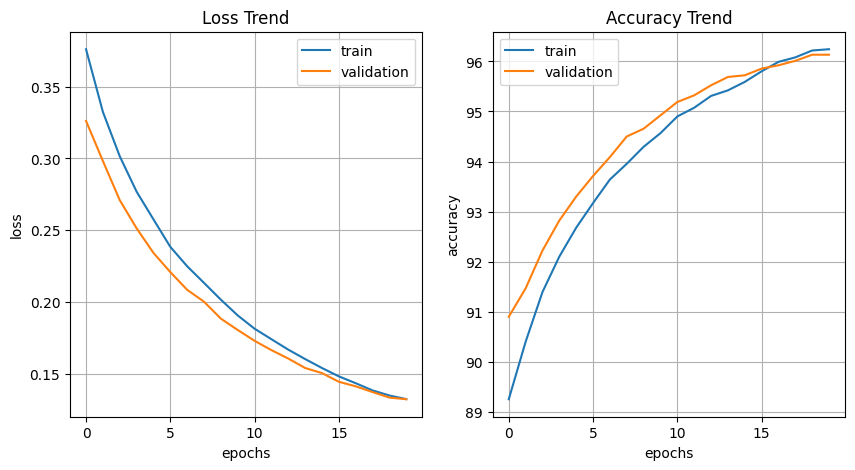

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()
